In [2]:
# Initialize Otter
import otter
grader = otter.Notebook("assignment3.ipynb")

# Assignment 3: Exploratory Data Analysis in Professional Basketball

In this assignment we'll conduct an exploratory data analysis of professional basketball data.  Basketball is a team sport in which the goal is to try to outscore the amount in a fixed amount of time. Points are scored (either 2 or 3 points) by putting the ball throw a hoop on one end of the court.  An attempt at putting the ball throw the hoop is known as a "shot".  If helpful, you can read more about [the rules of basketball](https://en.wikipedia.org/wiki/Rules_of_basketball).

The National Basketball Association (NBA) is the professional basketball league in the United States and provides a nice website with many statistics gathered on teams and players in the league: [http://stat.nba.com](http://stat.nba.com). 

<!-- BEGIN QUESTION -->

## Question 1: Managing data files

We will use data that is available from NBA. Although NBA doesn't officially make the data API (application programming interface) public, people have figured out ways to access their data programmatically ([1](https://github.com/swar/nba_api), [2](https://github.com/seemethere/nba_py/wiki/stats.nba.com-Endpoint-Documentation)). However, NBA does not offer an official API and it is possible to get our JupyterHub blocked by the site if we use them. Therefore, in this assignment, the raw data downloads are provided to you in a zip file: https://ucsb.box.com/shared/static/z6y3etgikbzbnf0ld4brvc95xtgjcrie.zip

Download and unzip the file to a directory named `data` using command line commands (unzipping on Windows and Mac may not work because different OS have different constraints on filename lengths, etc.). Adding an exclamation point in the Jupyter notebook cell indicates that `bash` shell interpreter will execute your command.
```bash
wget -nc https://ucsb.box.com/shared/static/z6y3etgikbzbnf0ld4brvc95xtgjcrie.zip -O nba-data.zip
unzip -o nba-data.zip -d data
```
What these commands are doing:
* `wget` downloads files ([what do each of the pieces do?](https://explainshell.com/explain?cmd=wget+-nc+https%3A%2F%2Fucsb.box.com%2Fshared%2Fstatic%2F940qiuxyp798gv4nx8iwvazu9qqjs37e.zip+-O+nba-data.zip))
* `unzip` will unzip `nba-data.zip` into a directory named `data` (specified by `-d data`) and will overwrite any same filenames when extracting (specified by `-o`).

<!-- END QUESTION -->

After unzipping the files, you will find three types of files in `data/` directory:

* Team data: `commonTeamYears?LeagueID=00&Season=2018-19`
* Player data: `commonallplayers?LeagueID=00&Season=2018-19&IsOnlyCurrentSeason=0`
* Player's shot data: `shotchartdetail?PlayerID=[PlayerID]&PlayerPosition=&Season=2018-19&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&Month=0&OpponentTeamID=0&Outcome=&Period=0&Position=&RookieYear=&SeasonSegment=&`

Each player's shot data is identified by replacing `[PlayerID]` with their numeric ID.

Here is how we will read in the data:
* Each data file contains text in [JSON (Javascript Object Notation) format](https://www.w3schools.com/python/python_json.asp).
* First, read the data content as text (using [Path.read_text()](https://docs.python.org/3/library/pathlib.html#pathlib.Path.read_text) from `pathlib` module)
* Second, we convert it to a Python dictionary format (using [json.loads()](https://docs.python.org/3/library/json.html#json.loads) in `json` module)
* Third, identify DataFrame content 
* Fourth, identify DataFrame header
* Fifth, assemble DataFrame

Another way to unzip a file is using `zipfile`.

In [2]:
import zipfile
with zipfile.ZipFile('nba-data.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

### Question 1a: Team Data

Read team data file into a pandas data frame named `allteams` starting from the given code below.

In [3]:
from pathlib import Path
import json
import pandas as pd
import numpy as np

fname  = 'data/commonTeamYears?LeagueID=00&Season=2018-19' # directory_name/file_name
step_1 = Path(fname).read_text()              # str
step_2 = json.loads(step_1)                   # dict
step_3 = step_2['resultSets'][0]['rowSet']    # list 
step_4 = step_2['resultSets'][0]['headers']   # list

In [4]:
# print out each of step_1 through step_4 and understand what each line does

In [5]:
step_1
step_2
step_3
step_4

['LEAGUE_ID', 'TEAM_ID', 'MIN_YEAR', 'MAX_YEAR', 'ABBREVIATION']

Use variables constructed above to assemble `allteams` DataFrame.

Drop any teams that no longer exist as of 2019. These teams show None in `ABBREVIATION` column.

Hint: We want to get rid of the NA's.

In [6]:
allteams = pd.DataFrame(data=step_3, columns = step_4)
allteams = allteams[allteams['MAX_YEAR'] == '2019']

In [7]:
grader.check("q1a")

q1a results: All test cases passed!

### Question 1b: Player Data

`pathlib` has flexible ways to specify file and directory paths. For example, the following are equivalent:

* `Path('data/commonallplayers?LeagueID=00&Season=2018-19&IsOnlyCurrentSeason=0')`
* `Path('data') / 'commonallplayers?LeagueID=00&Season=2018-19&IsOnlyCurrentSeason=0')`
* `Path('data').joinpath('commonallplayers?LeagueID=00&Season=2018-19&IsOnlyCurrentSeason=0')`

Read players data file with name `data/commonallplayers?LeagueID=00&Season=2018-19&IsOnlyCurrentSeason=0`. 
Assemble pandas DataFrame with name `allplayers`. Set row index to be `PERSON_ID` and then `sort_index`.


In [8]:
dirname  = 'data' # directory_name
filename = 'commonallplayers?LeagueID=00&Season=2018-19&IsOnlyCurrentSeason=0' # file_name
step_1 = Path(dirname).joinpath(filename).read_text()
step_2 = json.loads(step_1)
step_3 = step_2['resultSets'][0]['rowSet'] 
step_4 = step_2['resultSets'][0]['headers']
allplayers = pd.DataFrame(data=step_3, columns = step_4).set_index('PERSON_ID').sort_index()

In [9]:
grader.check("q1b")

q1b results: All test cases passed!

### Question 1c: Shots Data

`pathlib` can also find all filenames that match a given pattern using [`Path.glob()` method](https://docs.python.org/3/library/pathlib.html#pathlib.Path.glob).

For example, teams data and players data start with the pattern `common` followed by a wildcard `*`: `common*`. 

We can use this to retrieve two file names with one call:

In [10]:
two_files = Path('data').glob('common*') # generator: https://www.educative.io/edpresso/generator-vs-iterator-in-python
list(two_files)                          # list

[PosixPath('data/commonTeamYears?LeagueID=00&Season=2018-19'),
 PosixPath('data/commonallplayers?LeagueID=00&Season=2018-19&IsOnlyCurrentSeason=0')]

All file names for shots data start with `shotchartdetail`. 

Use this as the pattern to 
* First, read all file names into `allshots_files`
* Second, loop over each file in `allshots_files` and assemble a dataframe
* Third, add dataframe as an element in a list named `allshots_list` (each file is an data frame item in the list). 
* Fourth, concatenate all dataframes into one dataframe named `allshots`. Set the row index to be `PLAYER_ID` and then `sort_index`.


In [11]:
allshots_files = sorted(list(Path('data').glob('shotchartdetail*')))
allshots_list = []

for f in allshots_files:
    step_1 = Path(f).read_text()
    step_2 = json.loads(step_1)
    step_3 = step_2['resultSets'][0]['rowSet'] 
    step_4 = step_2['resultSets'][0]['headers']
    df = pd.DataFrame(data=step_3, columns = step_4)
    allshots_list.append(df)
    
allshots = pd.concat(allshots_list).set_index('PLAYER_ID').sort_index()

In [12]:
grader.check("q1c")

q1c results: All test cases passed!

### Question 1d: Extract Stephen Curry's Shot Data

Use [`allplayers.query()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.query.html) to find the player id (index) associated with the player named "[Stephen Curry](https://en.wikipedia.org/wiki/Stephen_Curry)".  Set the value of `PlayerID` as `curry_id` of type `str`. 

Subset all of Stephen Curry's shots in a data frame named `curry_data`. Also, set the dtype of `SHOT_MADE_FLAG` to `'bool'` in one command. Something like:  
```
curry_data = allshots.query(???).astype(????)
```

Hint: Try to look over the column names in `all_players` and find the one contains full names to fill in the `query_str`.

In [13]:
# fill-in all ...
query_str = 'DISPLAY_FIRST_LAST == "Stephen Curry"'
curry_id = str(allplayers.query(query_str).index.values[0])
curry_data = allshots.query('PLAYER_ID == ' + curry_id).astype({'SHOT_MADE_FLAG' : 'bool'})

In [14]:
grader.check("q1d")

q1d results: All test cases passed!

## Question 2: Visualization

### Question 2a: All Shots Scatter Plot
Use `seaborn` to create scatter plot of the location of Stephen Curry's shot attempts from this year (`LOC_X` and `LOC_Y`).  When you call a scatterplot, seaborn returns a figure in an object, we'll call it `ax`.  We can set properties of the figure by calling methods on `ax`.  Use this approach to set the x-axis limits to span (-300, 300), the y-axis limits to span (-100, 500).

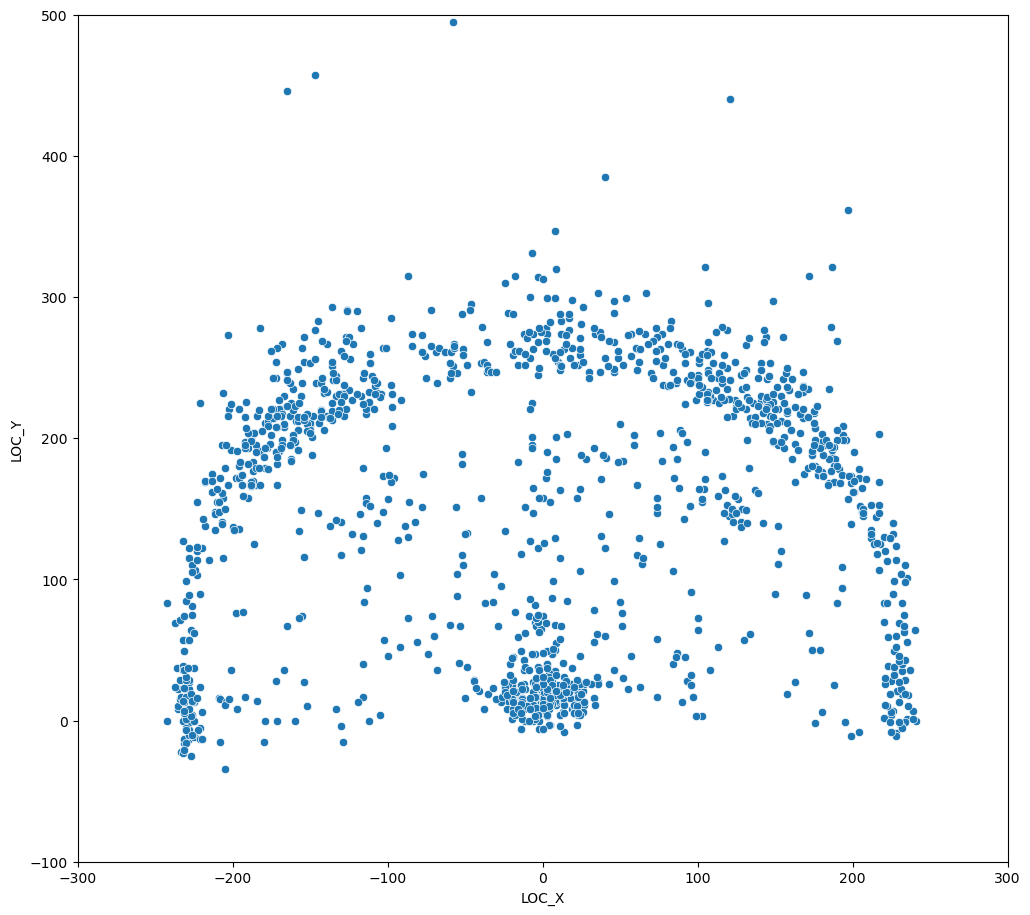

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=[12, 11])
ax2a = sns.scatterplot(x='LOC_X', y='LOC_Y', data=curry_data)

# Set x/y limits and labels
ax2a.set_xlim(-300, 300)
ax2a.set_ylim(-100, 500)
plt.show()

In [16]:
grader.check("q2a")

q2a results: All test cases passed!

Understanding any dataset is difficult without context.  Lets add some important context by adding the relevant court lines into our diagram.  If you are interested, you can read more about the lines and dimensions on the [NBA basketball court](https://en.wikipedia.org/wiki/Basketball_court).  We will use code from [http://savvastjortjoglou.com/nba-shot-sharts.html](http://savvastjortjoglou.com/nba-shot-sharts.html) to add the court markings to our diagram.  The `draw_court` function below will do this for us.  The below cell will generate an example court.

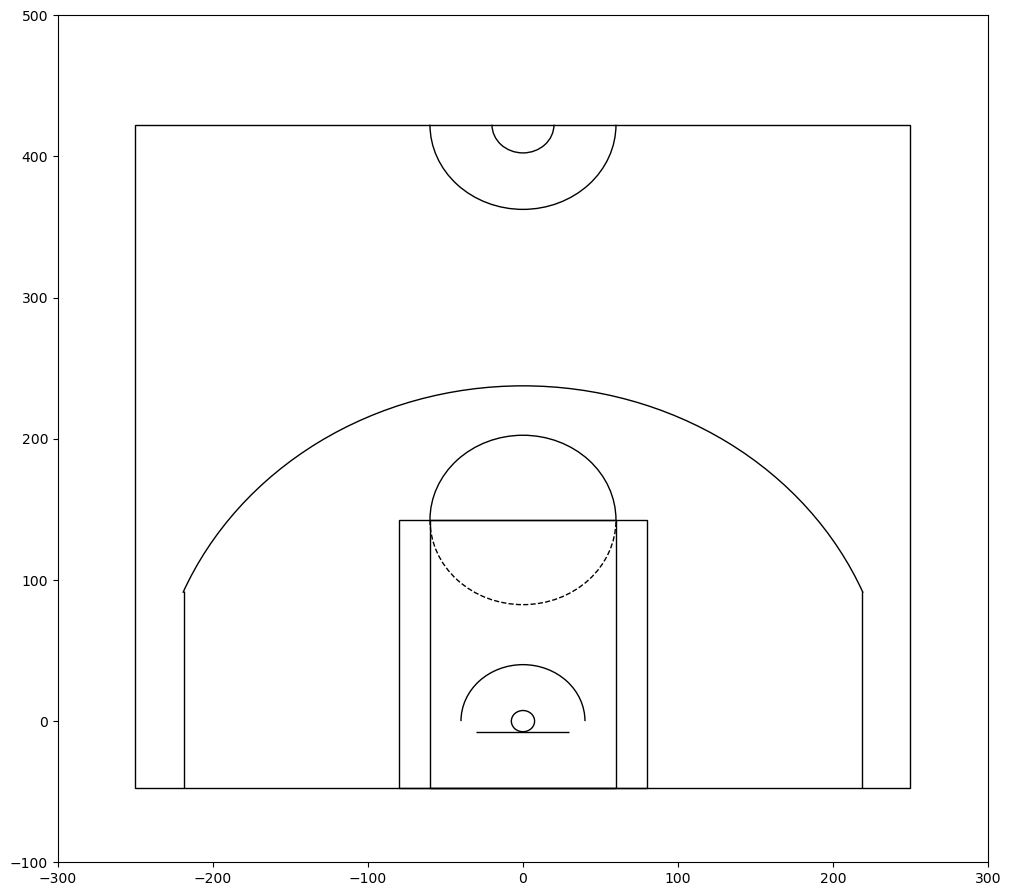

In [17]:
## code is from http://savvastjortjoglou.com/nba-shot-sharts.html
def draw_court(ax=None, color='black', lw=1, outer_lines=False):
    
    from matplotlib.patches import Circle, Rectangle, Arc
    from matplotlib.pyplot import gca
    
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, 0, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-219, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((219, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22.5, theta2=157.5, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half-court line, baseline and side-out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

plt.figure(figsize=(12,11))
draw_court(outer_lines=True)
plt.xlim(-300,300)
plt.ylim(-100,500)
plt.show()

<!-- BEGIN QUESTION -->

### Question 2b: All Shots Scatter Plot + Court Outline

Again use seaborn to make a scatter plot of Stephen Curry's shots. Again, set the x-axis limits to span (-300, 300), the y-axis limits to span (-100, 500) color the points by whether the shot was made or missed.  Set the missed shots to have an 'x' symbol and made shots to be a circular symbol. Call the `draw_court` function with `outer_lines` argument set to to be true. Save the `Axes` returned by the plot call in a variable called `ax`.


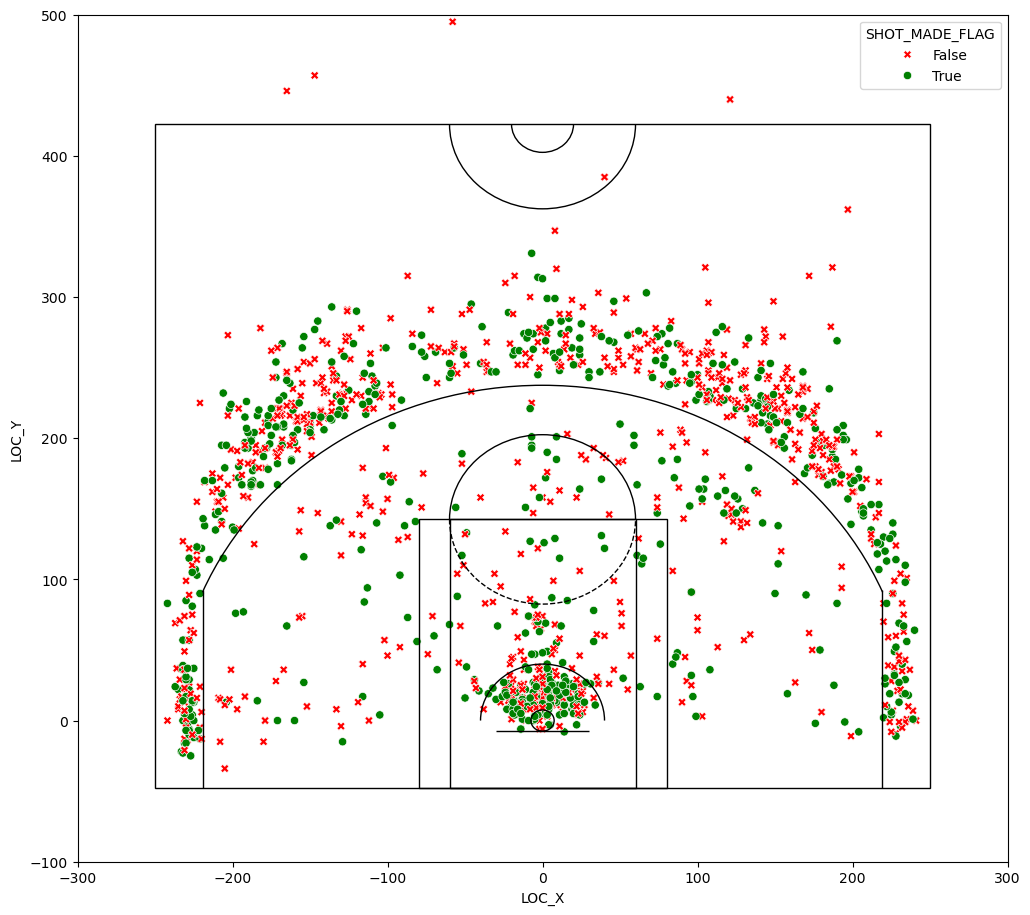

In [18]:
plt.figure(figsize=(12, 11))
markers = {0 : "X", 1 : "o"}
ax = sns.scatterplot(x='LOC_X', y='LOC_Y', hue='SHOT_MADE_FLAG', data=curry_data, palette={True: 'green', False: 'red'}, style='SHOT_MADE_FLAG', markers=markers)
ax.set_xlim(-300, 300)
ax.set_ylim(-100, 500)

draw_court(outer_lines=True)
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 2c: Analyzing the Visualization

In a few sentences, discuss what makes this an effective or ineffective visualization for understanding the types of shots that Stephen Curry likes to take and is good at taking, relative to other players in the league.  Are there ways it can be improved?

**SOLUTION**

This visualization is effeective for understanding the types of shots that Stephen Curry likes to take but there are some points that it can improve on. First, there are a lot of shots right around the hoop which can make it hard to see all the the shots in that area. (some points cover other points). It also can be quite hard to gage the percentage of shots that Curry made in the given range you are looking for. For example, we can see most of the points are right outside of the 3-point line and right next to the hoop. These are the places that Curry shoots from most often. When looking at the points outside of the 3-point line, it can be hard to accurately say the percentage of shots he made. One way that this plot could be improved is maybe by adding the percentage of shots made in specific regions. So, the plot could show the percentage of shots made inside the restricted area, or outside of the 3-point line.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 2d: A Hexbin plot

Visualize Stephen Curry's shots by using a [hexbin plot with marginal histograms](https://seaborn.pydata.org/examples/hexbin_marginals.html). Also refer to setting [figure aesthetics](https://seaborn.pydata.org/tutorial/aesthetics.html) for what commands below do.

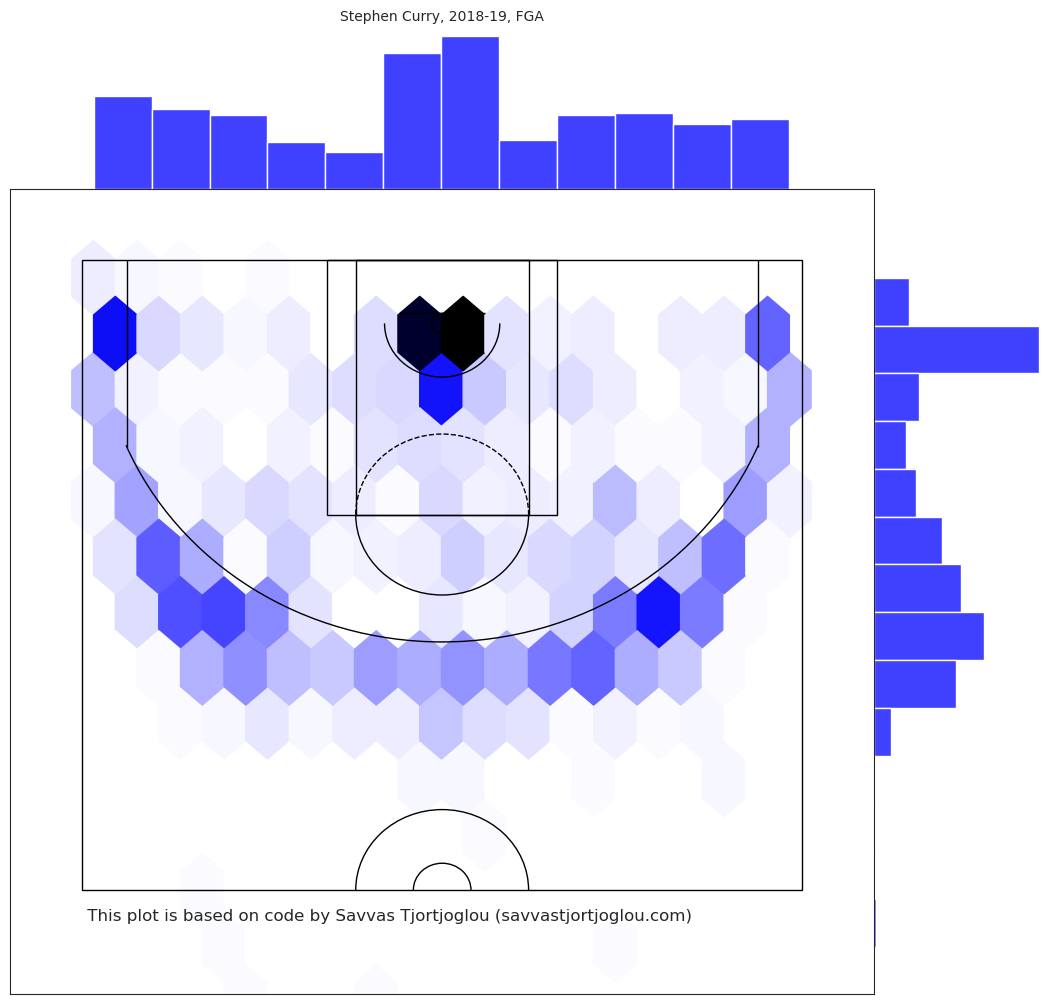

In [19]:
sns.set_style("white")
joint_shot_chart = sns.jointplot(x='LOC_X', y='LOC_Y', data=curry_data, kind='hex', space=0, color='b')
joint_shot_chart.fig.set_size_inches(12,11)

# A joint plot has 3 Axes, the first one called ax_joint 
# is the one we want to draw our court onto and adjust some other settings
ax = joint_shot_chart.ax_joint
draw_court(ax, outer_lines=True)

# Adjust the axis limits and orientation of the plot in order
# to plot half court, with the hoop by the top of the plot
ax.set_xlim(-300, 300)
ax.set_ylim(500, -100)

# Get rid of axis labels and tick marks
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(labelbottom=False, labelleft=False)

# Add a title
ax.set_title('Stephen Curry, 2018-19, FGA', 
             y=1.2, fontsize=10)

# Add Data Source and Author
ax.text(-250,445,'\n This plot is based on code by Savvas Tjortjoglou (savvastjortjoglou.com)',
        fontsize=12);

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## Question 2e: A Contour Plot

Another way to visualize Stephen Curry's shots is using contours. We can use `distplot()` for 2D data in `seaborn` to visualize the distribution of missed shots and made shots.

Also visualize the distribution of shots in different shot area (`SHOT_ZONE_AREA`) by contour plots and display them in 2 rows.

Hint: See the [document](https://seaborn.pydata.org/tutorial/distributions.html) for `distplot()`.

In [20]:
curry_data.head()

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
PLAYER_ID,,,,,,,,,,,,,,,,,,,,,
201939,Shot Chart Detail,0021800862,117,Stephen Curry,1610612744,Golden State Warriors,1,3,55,Made Shot,...,Center(C),16-24 ft.,17,2,172,1,True,20190213,POR,GSW
201939,Shot Chart Detail,0021800862,600,Stephen Curry,1610612744,Golden State Warriors,4,5,9,Missed Shot,...,Right Side Center(RC),24+ ft.,26,116,239,1,False,20190213,POR,GSW
201939,Shot Chart Detail,0021800862,576,Stephen Curry,1610612744,Golden State Warriors,4,6,55,Missed Shot,...,Right Side(R),24+ ft.,22,225,28,1,False,20190213,POR,GSW
201939,Shot Chart Detail,0021800862,484,Stephen Curry,1610612744,Golden State Warriors,3,2,24,Missed Shot,...,Left Side(L),24+ ft.,23,-235,8,1,False,20190213,POR,GSW
201939,Shot Chart Detail,0021800862,467,Stephen Curry,1610612744,Golden State Warriors,3,3,3,Missed Shot,...,Right Side(R),16-24 ft.,22,193,109,1,False,20190213,POR,GSW


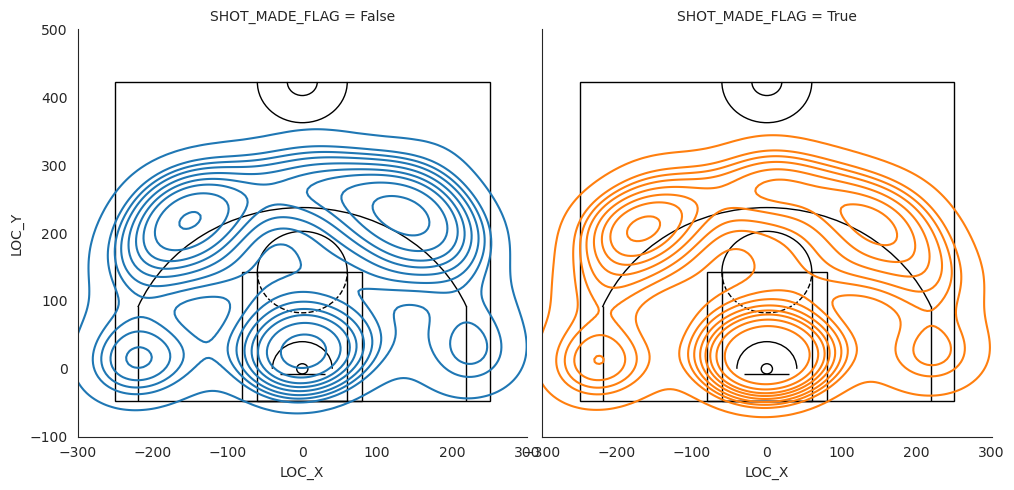

In [21]:
# Visualize Stephen Curry's made and missed shots
# Fill-in ...
contour_miss_made= sns.displot(x='LOC_X', y='LOC_Y', data=curry_data, kind='kde', legend = False, col = 'SHOT_MADE_FLAG' , hue  = 'SHOT_MADE_FLAG', col_wrap = 2) 
for ax in contour_miss_made.axes.flat:
    ax = draw_court(ax, outer_lines=True)
    ax.set_xlim(-300,300)
    ax.set_ylim(-100,500)

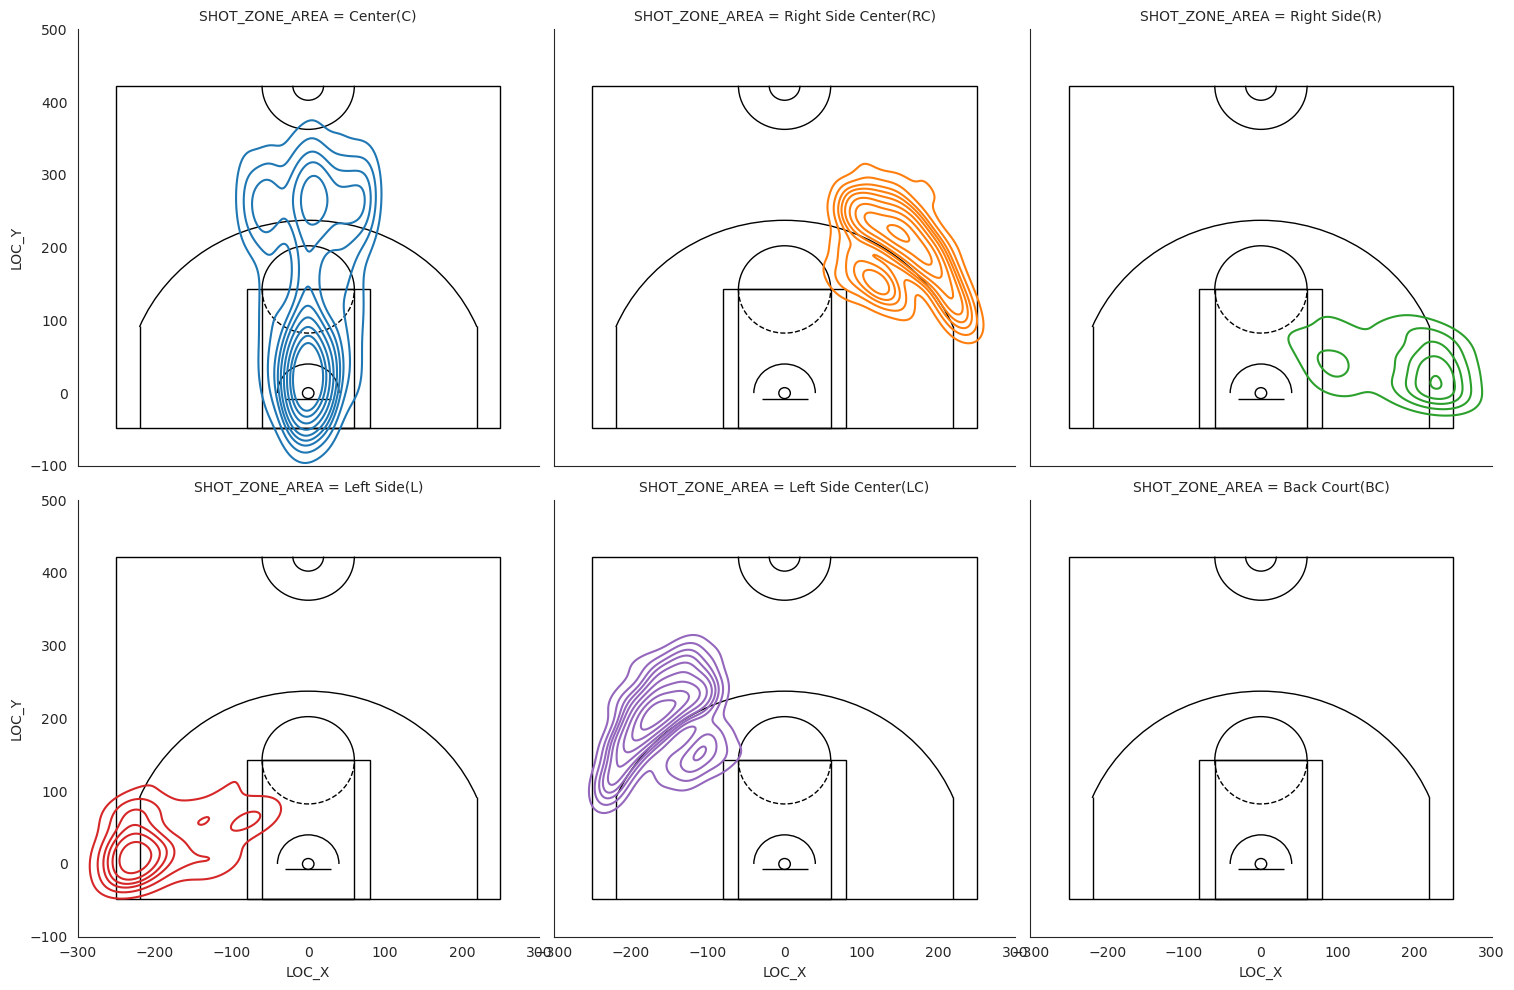

In [22]:
# Visualize Stephen Curry's shots' area
# Fill-in ...
contour_area = sns.displot(x='LOC_X', y='LOC_Y', data=curry_data, kind='kde', legend = False, col ='SHOT_ZONE_AREA', hue = 'SHOT_ZONE_AREA', col_wrap = 3) 
for ax in contour_area.axes.flat:
    ax = draw_court(ax, outer_lines=True)
    ax.set_xlim(-300,300)
    ax.set_ylim(-100,500)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Comment the advantages and disadvantages of contour plots comparing with hexibin plot(Q2d) and scatter plot(Q2b).

**Solution**

the contour plots are good for showing the density of shots that Curry took. An advantage of using contour plots over plotting individual shots is that it is easy to see the regions that Curry likes to shoot from. A disadvantage from using the contout plots is that it makes it hard to visualize the percentage of made shots vs missed shots. The hexbin plot is the easiest to understand but does not tell you as much information as the contour plots we made.

<!-- END QUESTION -->

## Question 3: Binning and Smoothing Shots

So far, in we have worked with dataframes which represent each shot as a single observation (row) within the dataset.  However, this isn't a convenient data structure for the kinds of spatial analyses we will pursue below.

In this part, we will divide the court into square regions and create a matrix which includes the number of shots taken by a player in that region.  We divide the court up into square bins (i.e. a 2d histogram) and, for each player, count number of shots that fall into each bin. Fortunately, this function is relatively simple to write using `numpy` module. 

### Question 3a: 2D Smoothing

Fill in the `bin_shots` function below. Use `np.histgram2d` to count the shots in each bin.  The bins are defined as `bin_edges` which is a pandas Series of the form `(xedges, yedges)`.  If `density = True`, call `ndimage.gaussian_filter` on the result of `np.histogram2d` with smoothing parameter `sigma`.  This will create a smoothed version of the raw data histograms.

In [23]:
def bin_shots(df, bin_edges, density=False, sigma=1):
    
    """Given data frame of shots, compute a 2d matrix of binned counts is computed
    
    Args:
        df: data frame of shotchartdetail from nba.com. 
            At the minimum, variables named LOCX and LOCY are required.
        bin_edges: bin edge definition: edges in x and edges in y
    
    Returns:
        binned: counts
        xedges: bin edges in X direction
        yedges: bin edges in Y direction
    """
    import numpy as np
    from scipy import ndimage
    
    ## Call np.histogram2d
    binned, xedges, yedges = np.histogram2d(x=df['LOC_X'], y=df['LOC_Y'],bins = bin_edges)
    
    if density:

        # Recompute 'binned' using "gaussian_filter"
        binned = ndimage.gaussian_filter(binned, sigma=sigma)
        
        # Normalize the histogram to be a "density", e.g. mass across all bins sums to 1.
        binned /= np.sum(binned)
    
    return(binned, xedges, yedges)


In [24]:
grader.check("q3a")

q3a results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 3b: Visualize the binning on `curry_data`

Call `bin_shots` on `curry_data` to create a binned but unsmoothed matrix of shot counts (call this `curry_binned_unsmoothed`), a binned and smoothed matrix of counts with `sigma=1` (call this `curry_binned_smoothed1`) and one with `sigma=5` (call this `curry_binned_smoothed5`). Use the bin edges defined below:

In [25]:
## bin edge definitions in inches
xedges = np.linspace(start=-300, stop=300, num=151)
yedges = np.linspace(start=-48, stop=372, num=106)

In [26]:
bin_edges = (xedges, yedges)
# fill-in all ...
curry_binned_unsmoothed, xe, ye = bin_shots(curry_data, bin_edges, density=False)
curry_binned_smoothed1,  xe, ye = bin_shots(curry_data, bin_edges, density=True, sigma=1)
curry_binned_smoothed5,  xe, ye = bin_shots(curry_data, bin_edges, density=True, sigma=5)

In [27]:
def plot_shotchart(binned_counts, xedges, yedges, ax=None, use_log=False, cmap = 'Reds'):
    
    """Plots 2d heatmap from vectorized heatmap counts
    
    Args:
        hist_counts: vectorized output of numpy.histogram2d
        xedges, yedges: bin edges in arrays
        ax: figure axes [None]
        use_log: will convert count x to log(x+1) to increase visibility [False]
        cmap: Set the color map https://matplotlib.org/examples/color/colormaps_reference.html
    Returns:
        ax: axes with plot
    """
    
    import numpy as np
    import matplotlib.pyplot as plt
    
    ## number of x and y bins.  
    nx = xedges.size - 1
    ny = yedges.size - 1

    X, Y = np.meshgrid(xedges, yedges)
    
    if use_log:
        counts = np.log(binned_counts + 1)
        
    if ax is None:
        fig, ax = plt.subplots(1,1)
    
    ax.pcolormesh(X, Y, binned_counts.T, cmap=cmap) 
    ax.set_aspect('equal')
    
    draw_court(ax)
    
    return(ax)

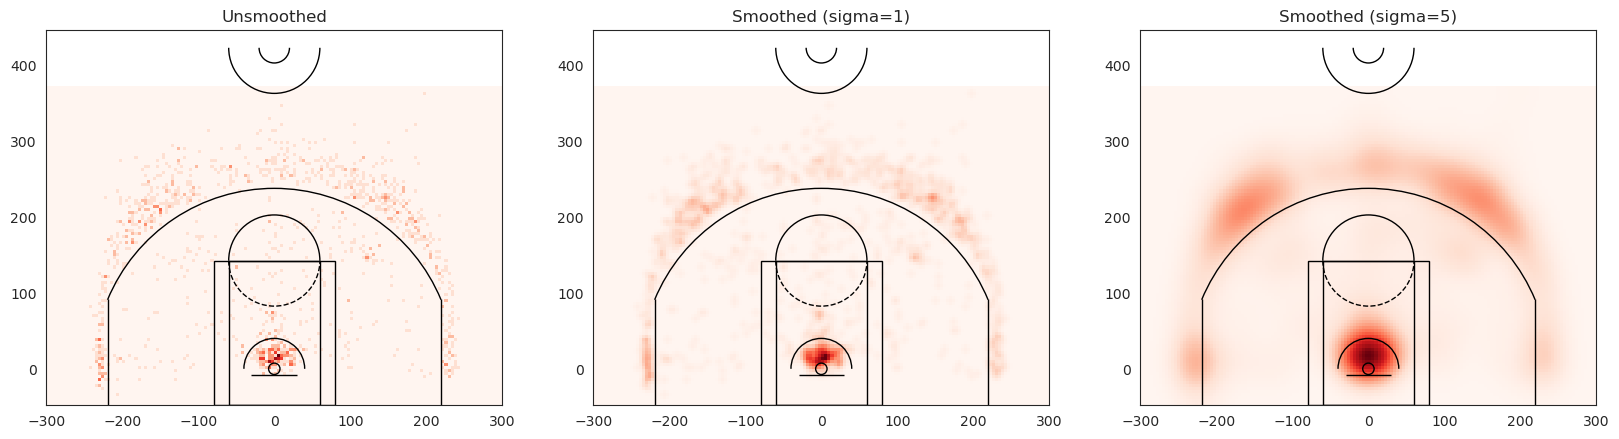

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(20,60))

plot_shotchart(curry_binned_unsmoothed, xe, ye, ax=ax[0], use_log=False, cmap='Reds')
ax[0].set_title('Unsmoothed')

plot_shotchart(curry_binned_smoothed1, xe, ye, ax=ax[1], use_log=False, cmap='Reds')
ax[1].set_title('Smoothed (sigma=1)')

plot_shotchart(curry_binned_smoothed5, xe, ye, ax=ax[2], use_log=False, cmap='Reds')
ax[2].set_title('Smoothed (sigma=5)')

fig.show()

<!-- END QUESTION -->

### Vectorize Shot Images

- Here we proceed create a dictionary of smoothed patterns, each vectorized into a 1-d array (like Lab 6)
- In this case, the object `all_smooth` is a dictionary that consists of arrays of length `15750`. 
- Each entry in `all_smooth` represents the smoothed frequency of shots along the bins generated in the code above for a given player.

In [29]:
## number of bins is one less than number of edges (remember homework 1)
nx = xedges.size - 1
ny = yedges.size - 1

## 2d histogram containers for binned counts and smoothed binned counts
all_counts = []
all_smooth = []
pids = []

## 2d histogram containers for binned counts and smoothed binned counts

## data matrix: players (row) by vectorized 2-d court locations (column)
for i, one in enumerate(allshots.groupby('PLAYER_ID')):
    
    ## what does this line do?
    pid, pdf = one
        
    num_shots = len(pdf.index)
    if(num_shots > 100): 
        
        tmp1, xedges, yedges = bin_shots(pdf, bin_edges=(xedges, yedges), density=True, sigma=2)
        tmp2, xedges, yedges = bin_shots(pdf, bin_edges=(xedges, yedges), density=False)
    
        ## vectorize and store into list
        all_smooth += [tmp1.reshape(-1)]
        all_counts += [tmp2.reshape(-1)]
        pids += [pid]
        
X = np.vstack(all_smooth).T
p, n = X.shape

print('Number of shot regions (p):', p)
print('Number of players (n):', n)

Number of shot regions (p): 15750
Number of players (n): 388


## Question 4: Non-negative Matrix Factorization (NMF) 

The non-negative matrix factorization is a dimension reduction technique that is often applied to image data.  It is similar to PCA except that is only applicable for strictly positive data.  We can apply the NMF to vectorized versions of the shot surface. This is useful because we can convert the observed matrix of shot surfaces into:
* Bases: Identifying modes of shooting style (number of modes is determined by `n_components` argument to `NMF` function below)
* Coefficients: How each players shooting style could be expressed as a (positive) linear combination of these bases

The NMF solves the following problem: given some matrix $X$ is $p\times n$ matrix, NMF computes the following factorization:
$$ \min_{W,H} \| X - WH \|_F\\
\text{ subject to } W\geq 0,\ H\geq 0, $$
where $W$ is ${p\times r}$ matrix and $H$ is ${r\times n}$ matrix.

In this homework, we have the following:
 
#### The data matrix $X$ 
$X$ is of dimension $n$={number of players} and $p$={number of total square bins on the court}. Each column corresponds to a player, with entries corresponding to a "flattened" or "vectorized" version of the 2d histograms plotted in part 4b.

#### Bases matrix: $W$

Columns $W_i$ contain the shot "bases". First, we will try it with $r=3$ bins in 5a, and then with $r=10$ bins in 5d.

#### Coefficient matrix: H

Each column of $H$ gives a coefficient for each of the bases vectors in $W$, and there are $n$ columns for each player.


The `sklearn` library is one of the main Python machine learning libraries.  It has a built in NMF function for us.  The function below runs this function and normalizes the basis surfaces to sum to 1.

In [30]:
## Non-negative Matrix Factorization
def non_negative_matrix_decomp(n_components, array_data):
    import sklearn.decomposition as skld
    model = skld.NMF(n_components=n_components, init='nndsvda', max_iter=500, random_state=0)
    W = model.fit_transform(array_data)
    
    # Normalize basis vectors to sum to 1
    Wsum = W.sum(axis=0)
    W = W/Wsum
    
    ## fix H correspondingly
    H = model.components_
    H = (H.T * Wsum).T

    nmf = (W, H)
    return(nmf)

### Question 4a: Computing NMF Factorization

Compute the NMF on all player's shot charts, X, assuming with `n_components` = 3 (i.e. each shot chart can be represented as a positive linear combination of 3 "basis" shot charts).  

In [31]:
# fill in ...
W3, H3 = non_negative_matrix_decomp(3, X)

In [32]:
grader.check("q4a")

q4a results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 4b: Visualizing Shot Types

Plot the first three basis images by calling `plot_vectorized_shot_chart` below on the columns of `W3`.

Fill in `plot_vectorized_shot_chart`.  This takes a the a vector of binned shot counts, converts it back to a matrix of the appropriate size and then calls `plot_shotchart` on the matrix.  The numpy function `reshape` will be useful here: [https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html](https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html)

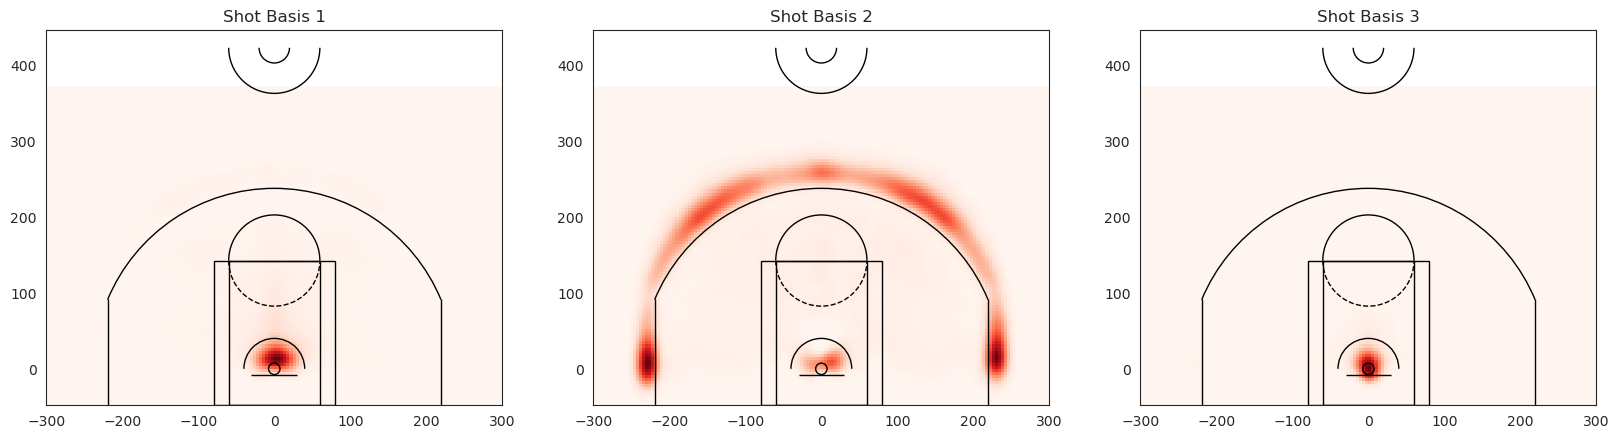

In [33]:
def plot_vectorized_shotchart(vec_counts, xedges, yedges, ax=None, use_log=False, cmap = 'Reds'):
    
    """Plots 2d heatmap from vectorized heatmap counts
    
    Args:
        hist_counts: vectorized output of numpy.histogram2d
        xedges, yedges: bin edges in arrays
        ax: figure axes [None]
        use_log: will convert count x to log(x+1) to increase visibility [False]
        cmap: Set the color map https://matplotlib.org/examples/color/colormaps_reference.html
    Returns:
        ax: axes with plot
    """

    nx = xedges.size - 1
    ny = yedges.size - 1
    
    # use reshape to convert a vectorized counts back into a 2d histogram
    two_d_counts = np.reshape(vec_counts, (nx, ny))
    
    return(plot_shotchart(two_d_counts, xedges, yedges, ax=ax, use_log=use_log, cmap=cmap))

fig, ax = plt.subplots(1, 3, figsize=(20,60))

## Write a for loop
for i in range(3):
    # Call plot_vectorized_shot_chart
    plot_vectorized_shotchart(W3[:, i], xe, ye, ax=ax[i], use_log=False, cmap='Reds')
    ax[i].set_title('Shot Basis %i' % (i+1))

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 4c: Reconstruction Error

Below we re-construct the shooting pattern for a single player. By "reconstructing" we mean use the approximation $$\hat{X} = WH$$ obtained via NMF.  Find $\hat X$ by multipling W and H.  In python the `@` symbol is used for matrix multiplication.


In [34]:
X3_hat = W3 @ H3

In [35]:
allplayers[allplayers['DISPLAY_FIRST_LAST'] == 'LaMarcus Aldridge']

,DISPLAY_LAST_COMMA_FIRST,DISPLAY_FIRST_LAST,ROSTERSTATUS,FROM_YEAR,TO_YEAR,PLAYERCODE,TEAM_ID,TEAM_CITY,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CODE,GAMES_PLAYED_FLAG,OTHERLEAGUE_EXPERIENCE_CH
PERSON_ID,,,,,,,,,,,,,
200746,"Aldridge, LaMarcus",LaMarcus Aldridge,1,2006,2019,lamarcus_aldridge,1610612759,San Antonio,Spurs,SAS,spurs,Y,00


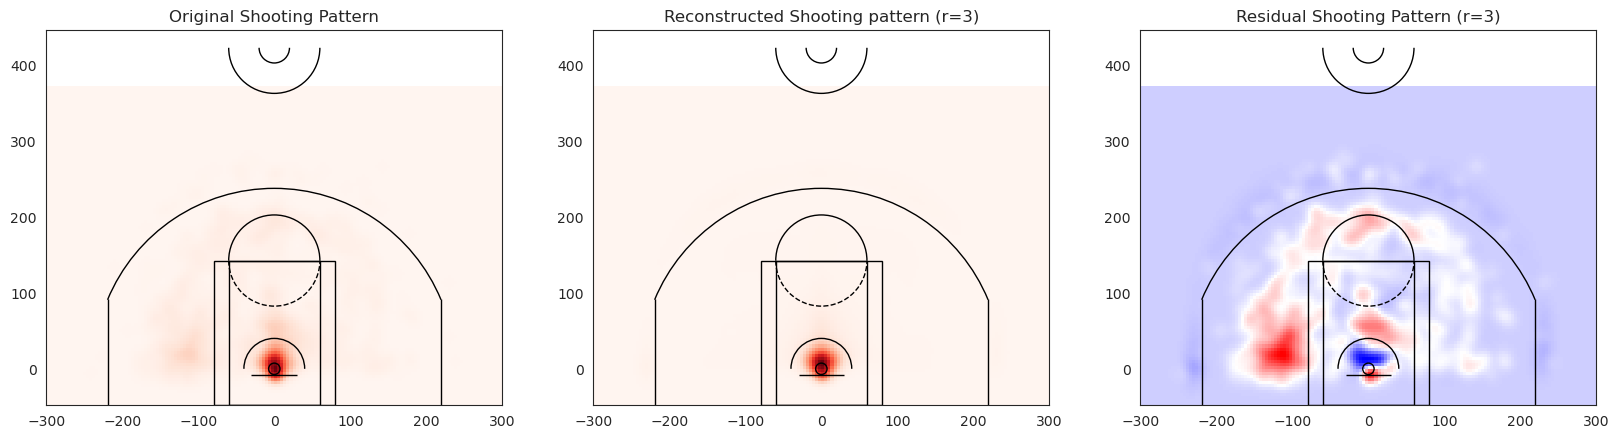

In [36]:
# Find the player_id of LaMarcus Aldridge

player_id = 200746

## find index in X corresponding to that player
to_plot_idx = np.where(np.array(pids) == player_id)[0][0]

fig, ax = plt.subplots(1, 3, figsize=(20,60))

## Call plot_vectorized_shot_chart
original_shotchart = X[:, to_plot_idx]
plot_vectorized_shotchart(original_shotchart, xe, ye, ax=ax[0], use_log=False, cmap='Reds')

reconstructed_shotchart = X3_hat[:, to_plot_idx]
plot_vectorized_shotchart(reconstructed_shotchart, xe, ye, ax=ax[1], use_log=False, cmap='Reds')

residual_chart = original_shotchart - reconstructed_shotchart
plot_vectorized_shotchart(residual_chart, xe, ye, ax=ax[2], use_log=False, cmap='bwr')

# print(max(abs(X3_hat[:, to_plot_idx] - X[:, to_plot_idx])))
ax[0].set_title('Original Shooting Pattern')
ax[1].set_title('Reconstructed Shooting pattern (r=3)')
ax[2].set_title('Residual Shooting Pattern (r=3)')
None # prevents the title string from showing up as output

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 4d: Choice of Colormap

Why does it make sense to use a _sequential_ palette for the original and reconstructed shot charts and a _diverging_ palette for the residual?  _Hint:_ Read the introduction to colormaps [here](https://matplotlib.org/users/colormaps.html). 


**SOLUTION**

It makes sense to use a sequential colormap for the original and reconstructed shot charts because these charts represent continuous data without distinct categories. On the other hand, the diverging colormap is usedful for the residual chart because it highlights differences from the reconstructed pattern and original pattern.

What areas of the court does this player to shoot more and where less relative to the reconstructed area.  If its helpful, you can refer to court locations by name using this legend [here](https://en.wikipedia.org/wiki/Basketball_court#/media/File:Basketball_terms.png]).

**SOLUTION**

From the residual shooting pattern chart, we can see that LaMarcus Aldridge shoots less from the restricted area when comparing the reconstructed area vs the original shooting pattern. The players original shooting pattern shows that they like to shoot more from the short corner and top of the key than would be predicted by the reconstructed shooting pattern.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 4e: More Detailed Modeling

Re-run the analysis, this time for 10 basis vectors instead of 3.  Again plot the bases using `plot_vectorized_shotchart` on the columns of `W10`.

**Hint**: Study the following code
```
fig, ax = plt.subplots(2, 5, figsize=(20, 7))
ax = ax.flatten() # turn ax into a flat array
ax[0].set_title('hello')
ax[9].set_title('there')
fig.show()
```

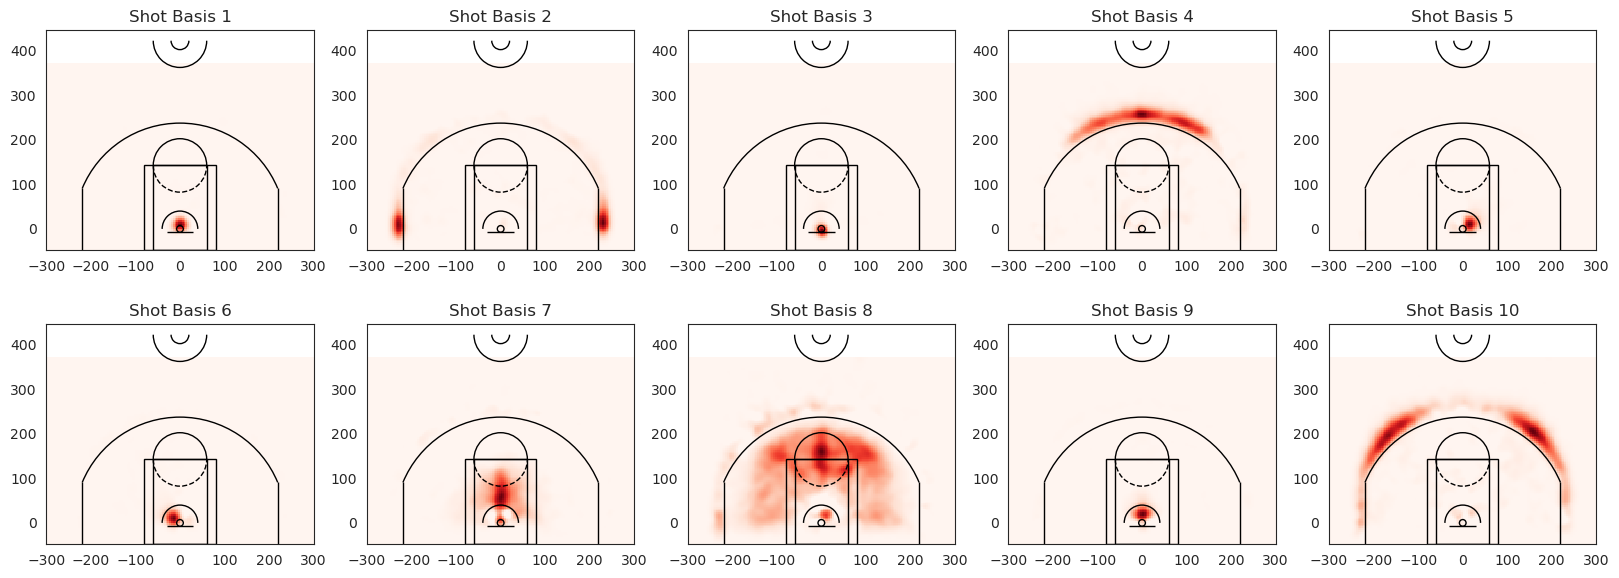

In [37]:
W10, H10 = non_negative_matrix_decomp(10, X)

fig, ax = plt.subplots(2, 5, figsize=(20, 7))

## Write a for loop
for i in range(10):
    plot_vectorized_shotchart(W10[:, i], xe, ye, ax=ax[i // 5, i % 5], use_log=False, cmap='Reds')
    ax[i//5, i % 5].set_title('Shot Basis %i' % (i+1))


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

If you did things correctly, you should be really impressed! We've identified potentially interesting patterns of shooting styles without actually specifying anything about the way basketball is played or where the relevant lines are on the court.  The resulting images are based only on the actual behavior of the players.  Even more impressive is that we're capturing similarity in regions that are far apart on the court.  One reason we can do this is that a basketball court is symmetric along the length of the court (i.e. symmetric about x=0).  However, people tend to be left or right hand dominant, which might affect their preferences.  Look carefuly at the shot basis plots above: is there any evidence of _asymmetry_ in player shooting behavior?  Refer to specific basis images in your answer.    


**SOLUTION**

Shot Basis 8 shows the most significant evvidence of asymmetry in player shooting behavior. We can see in this chart that there is a lot more red on the left side of the chart (which means the right side of the court in the game). This shows that there are more people shooting from the right side in a game which makes sense because most people are right handed.

<!-- END QUESTION -->

Repeat part 4(c), and again plot original, reconstructed and residual shot chats for LaMarcus Aldridge.


<!-- BEGIN QUESTION -->



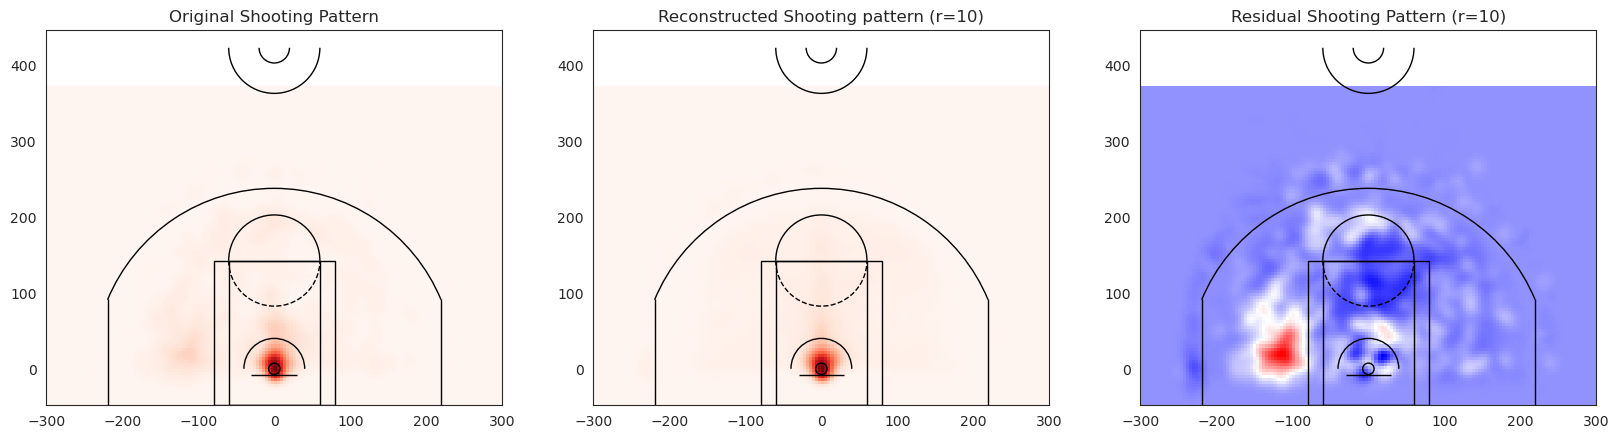

In [38]:
X10_hat = W10 @ H10

fig, ax = plt.subplots(1, 3, figsize=(20,60))

# I took the first player appearing in first column 
# (you probably want to do more interesting players)

original_shotchart = X[:, to_plot_idx]
plot_vectorized_shotchart(original_shotchart, xe, ye, ax=ax[0], use_log=False, cmap='Reds')

reconstructed_shotchart = X10_hat[:, to_plot_idx]
plot_vectorized_shotchart(reconstructed_shotchart, xe, ye, ax=ax[1], use_log=False, cmap='Reds')

residual_chart = original_shotchart - reconstructed_shotchart
plot_vectorized_shotchart(residual_chart, xe, ye, ax=ax[2], use_log=False, cmap='bwr')

ax[0].set_title('Original Shooting Pattern')
ax[1].set_title('Reconstructed Shooting pattern (r=10)')
ax[2].set_title('Residual Shooting Pattern (r=10)');

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 4f: Comparing Players 

With `H10` matrix, it is possible to compare any pair of players. For all players pairwise, $i$ and $j$, compare using euclidean distance between their coefficients:

$$ \text{player-distance}(i,j) = \| H_i - H_j \|_2 = \left(\sum_{k=1}^{10} (H_{ki} - H_{kj})^2 \right)^{1/2} $$

Create a heatmap for comparing pair-wise player distance matrix. Find the two pairs of players with the smallest distances. Also, find two pairs of players with largest distances.

Hint: you can construct the distance matrix manually or use `scipy.spatial.distance_matrix`.

**SOLUTION**

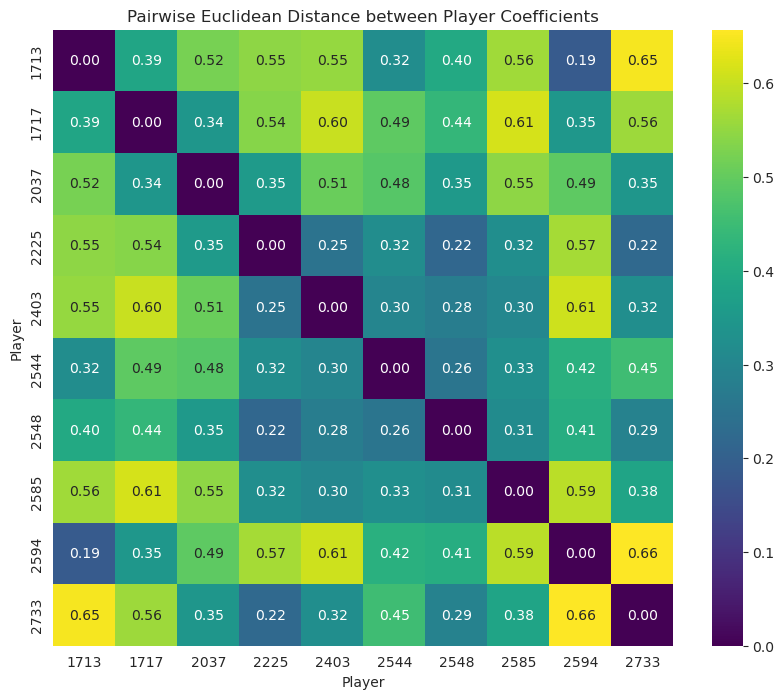

Two pairs of players with smallest distances:
203468   1627750    0.046518
1628370  1627736    0.051151
dtype: float64

Two pairs of players with largest distances:
203124  200782    1.016550
200782  101181    1.016156
dtype: float64


In [39]:
from scipy.spatial import distance_matrix
import seaborn as sns
import pandas as pd

# Compute the pairwise Euclidean distance matrix between player coefficients
distance_matrix = distance_matrix(H10.T, H10.T)

# Convert the distance matrix into a DataFrame for visualization
distance_df = pd.DataFrame(distance_matrix, index=pids, columns=pids)

#heatmap plot with first 10 columns and rows
subset_data = distance_df.iloc[:10, :10]

plt.figure(figsize=(10, 8))
sns.heatmap(subset_data, cmap='viridis', annot=True, fmt=".2f", cbar=True)
plt.title("Pairwise Euclidean Distance between Player Coefficients")
plt.xlabel("Player")
plt.ylabel("Player")
plt.show()

# Find the two pairs of players with the smallest distances
min_distances = distance_df.unstack().sort_values().drop_duplicates()
print("Two pairs of players with smallest distances:")
print(min_distances.head(3)[1:3])

# Find the two pairs of players with the largest distances
max_distances = distance_df.unstack().sort_values(ascending=False).drop_duplicates()
print("\nTwo pairs of players with largest distances:")
print(max_distances.head(2))


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 4g: Residuals

The residual betwene `Xhat` and `X` gives a sense of how well a player is decribed by NMF computed matrices `W` and `H`. Calculate RMSE for each player, and plot the histogram. Comment on this distribution and players with smallest and largest RMSEs (use 10 components).


**SOLUTION**

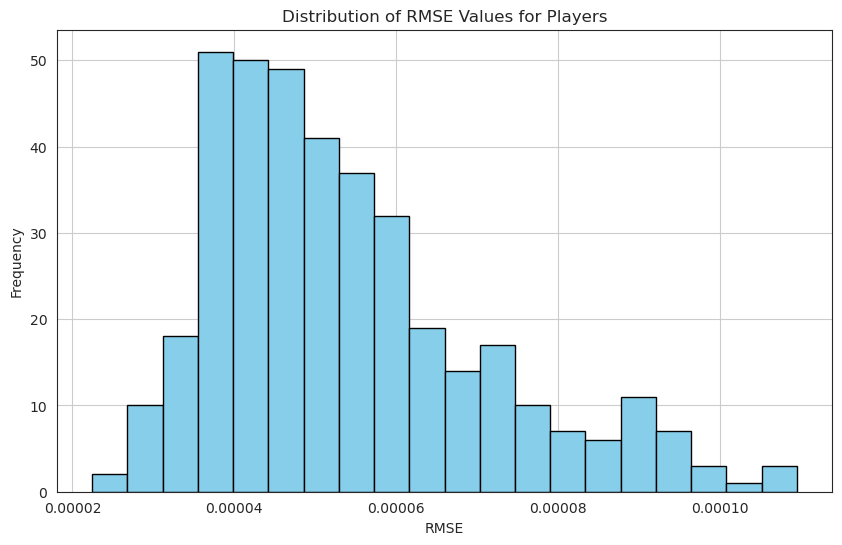

Player with smallest RMSE: 1626149
Player with largest RMSE: 202954


In [40]:
rmse_values = np.sqrt(np.mean((X - X10_hat) ** 2, axis=0))

# Plot histogram of RMSE values
plt.figure(figsize=(10, 6))
plt.hist(rmse_values, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of RMSE Values for Players')
plt.xlabel('RMSE')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Find players with smallest and largest RMSEs
smallest_rmse_idx = np.argmin(rmse_values)
largest_rmse_idx = np.argmax(rmse_values)

smallest_rmse_player = pids[smallest_rmse_idx]
largest_rmse_player = pids[largest_rmse_idx]

print("Player with smallest RMSE:", smallest_rmse_player)
print("Player with largest RMSE:", largest_rmse_player)

The players with largest RMSE's may have shooting patterns that deviate more from the reconstructed patterns we created and the players with the smallest RMSE's may have shooting patterns that are captured well by the NMF model. This distribution shows that most players have lower RMSE's with the mean between 0.00004 and 0.00006. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 4h: Proposing improvements

One of the main purposes of exploratory data analysis is to generate new ideas, directions, and hypothesis for future analyses and experiments. Take two players of your choice and compare their shooting patterns with various visualizations.

State any insights and defend your conclusions with visual and/or numerical comparisons.

**SOLUTION**

In [41]:
# allplayers
# allplayers[allplayers['DISPLAY_FIRST_LAST']=='Stephen Curry']
# allplayers[allplayers['TEAM_ID'] == 1610612744]

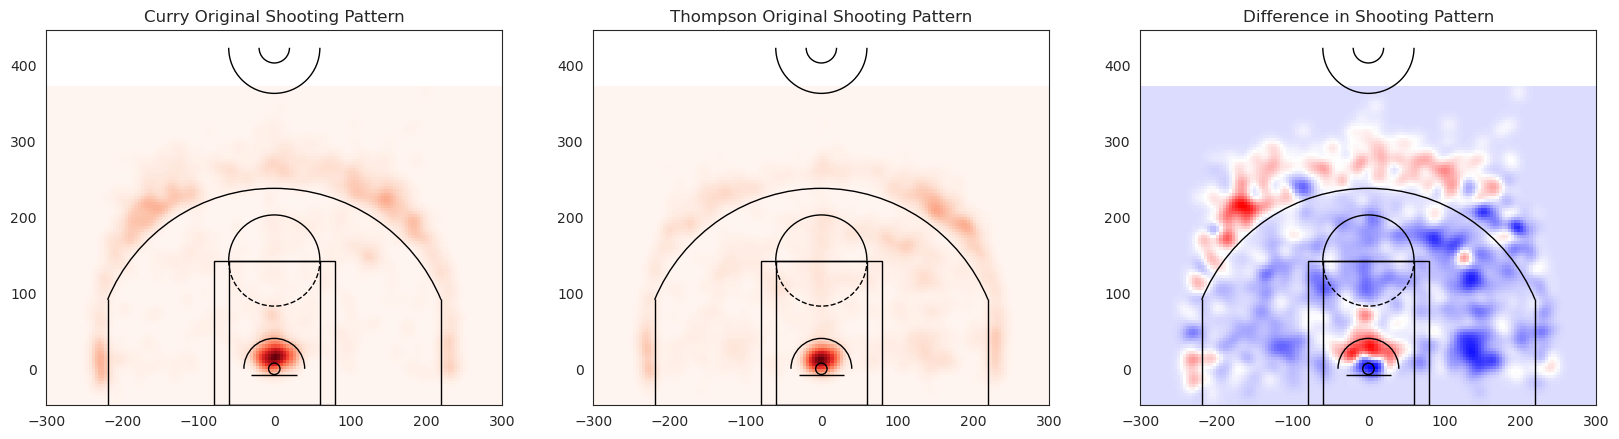

In [42]:
#201142 (Stephen Curry)      202691 (Klay Thompson)	

player_id1 = 201939
player_id2 = 202691

## find index in X corresponding to that player
to_plot_idx1 = np.where(np.array(pids) == player_id1)[0][0]
to_plot_idx2 = np.where(np.array(pids) == player_id2)[0][0]


fig, ax = plt.subplots(1, 3, figsize=(20,60))


## Call plot_vectorized_shot_chart
curry_original_shotchart = X[:, to_plot_idx1]
plot_vectorized_shotchart(curry_original_shotchart, xe, ye, ax=ax[0], use_log=False, cmap='Reds')

thompson_original_shotchart = X[:, to_plot_idx2]
plot_vectorized_shotchart(thompson_original_shotchart, xe, ye, ax=ax[1], use_log=False, cmap='Reds')

curry_thompson_difference = curry_original_shotchart - thompson_original_shotchart
plot_vectorized_shotchart(curry_thompson_difference, xe, ye, ax=ax[2], use_log=False, cmap='bwr')

ax[0].set_title('Curry Original Shooting Pattern')
ax[1].set_title('Thompson Original Shooting Pattern')
ax[2].set_title('Difference in Shooting Pattern')
None # prevents the title string from showing up as output

From these figures, we can see that Stephen curry likes to shoot from outside the 3-point line and from right on the restricted area line than Thompson Klay. Thompson Klay's data seems to be more distributed towards the right side of the chart, which most likely means that he plays on the left side of the field (because thats where most of his shots are taken). Next, I want to look at the contour plots of the two players and compare them to see if this stays consistent.

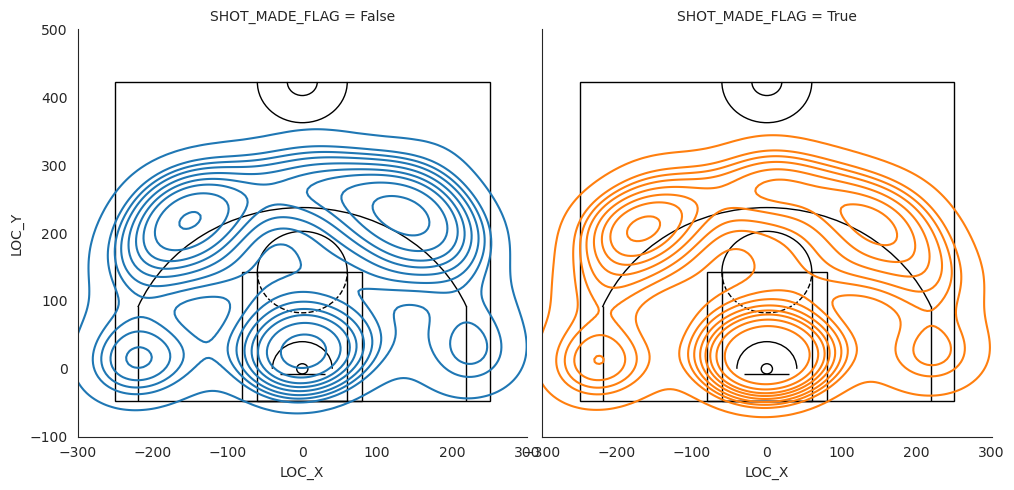

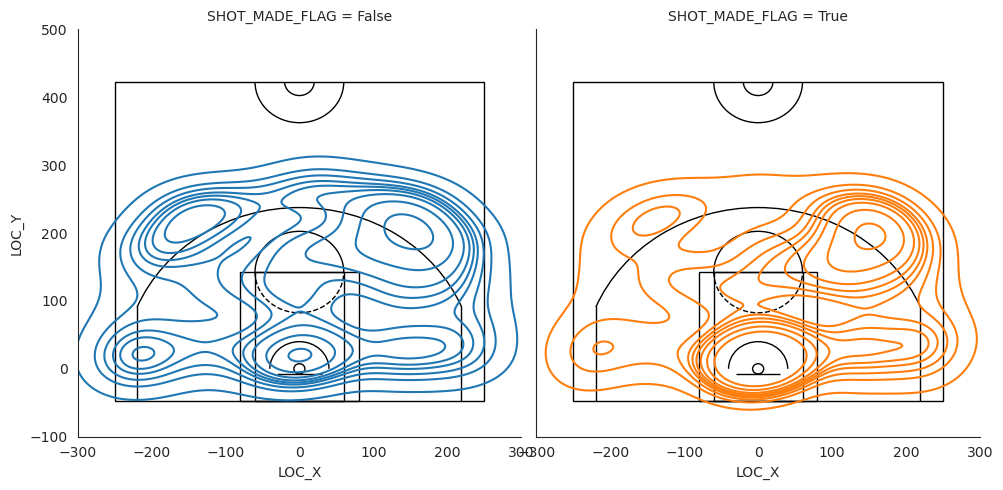

In [43]:
#Need to extract thompson Klay's data

query_str = 'DISPLAY_FIRST_LAST == "Klay Thompson"'
thompson_id = str(allplayers.query(query_str).index.values[0])
thompson_data =  allshots.query('PLAYER_ID == ' + thompson_id).astype({'SHOT_MADE_FLAG' : 'bool'})

#contour plots of the two players

contour_miss_made_curry = sns.displot(x='LOC_X', y='LOC_Y', data=curry_data, kind='kde', legend = False, col = 'SHOT_MADE_FLAG' , hue  = 'SHOT_MADE_FLAG', col_wrap = 2) 
for ax in contour_miss_made_curry.axes.flat:
    ax = draw_court(ax, outer_lines=True)
    ax.set_xlim(-300,300)
    ax.set_ylim(-100,500)


contour_miss_made_thompson = sns.displot(x='LOC_X', y='LOC_Y', data=thompson_data, kind='kde', legend = False, col = 'SHOT_MADE_FLAG' , hue  = 'SHOT_MADE_FLAG', col_wrap = 2) 
for ax in contour_miss_made_thompson.axes.flat:
    ax = draw_court(ax, outer_lines=True)
    ax.set_xlim(-300,300)
    ax.set_ylim(-100,500)

From the contour plots, we can see that Thompson is much more consistent when shooting on the left side of the court. Most of his successfull shots are from the left side and layups. Stephen Curries shots are more spread out through the court which makes me believe that he is a more central player while Thompson plays more on the left side of the field. 

<!-- END QUESTION -->

_Cell Intentionally Blank_

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

Download the zip file and submit to Gradescope.

In [3]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)

Running your submission against local test cases...


Your submission received the following results when run against available test cases:

    q1a results: All test cases passed!

    q1b results: All test cases passed!

    q1c results: All test cases passed!

    q1d results: All test cases passed!

    q2a results: All test cases passed!

    q3a results: All test cases passed!

    q4a results: All test cases passed!
